In [1]:
!pip install torch torchvision torchaudio


Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import numpy as np 
import torch        
from torch.utils.data import Dataset,DataLoader,ConcatDataset   
import glob        
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,accuracy_score
import cv2  
import random
import sys  

In [4]:
tumor=[]
healthy=[]
for f in glob.iglob(r"C:\Users\ulkar\Downloads\yes\*.*"):
    img=cv2.imread(f)
    img=cv2.resize(img,(128,128))
    b,g,r=cv2.split(img)
    img=cv2.merge([r,g,b])
    tumor.append(img)
for f in glob.iglob(r"C:\Users\ulkar\Downloads\no\*.*"):
    img=cv2.imread(f)
    img=cv2.resize(img,(128,128))
    b,g,r=cv2.split(img)
    img=cv2.merge([r,g,b])
    healthy.append(img)
    

In [5]:
healthy=np.array(healthy,dtype=np.float32)
tumor=np.array(tumor,dtype=np.float32)
All=np.concatenate((healthy,tumor))

In [6]:
healthy.shape

(98, 128, 128, 3)

In [7]:
tumor.shape

(155, 128, 128, 3)

In [8]:
np.random.choice(10, 5, replace=False)

array([8, 6, 2, 4, 5])

In [9]:
def plot_random(healthy, tumor, num=5):
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Select random samples from each
    healthy_imgs = healthy[np.random.choice(healthy.shape[0], num, replace=False)]
    tumor_imgs = tumor[np.random.choice(tumor.shape[0], num, replace=False)]
    
    plt.figure(figsize=(16, 5))
    
    for i in range(num):
        # Normalize images for display
        h_img = healthy_imgs[i] / 255.0
        t_img = tumor_imgs[i] / 255.0
        
        plt.subplot(2, num, i + 1)
        plt.imshow(h_img)
        plt.title("Healthy")
        plt.axis('off')
        
        plt.subplot(2, num, i + 1 + num)
        plt.imshow(t_img)
        plt.title("Tumor")
        plt.axis('off')
    
    plt.show()

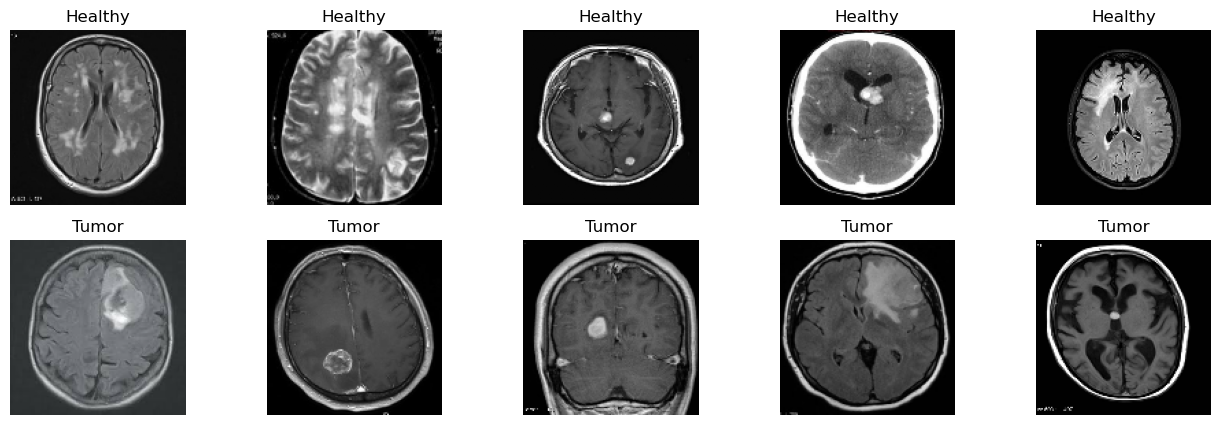

In [10]:
plot_random(healthy,tumor,num=5)

In [11]:
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])

In [12]:
class MRI(Dataset):
    def __init__(self):
        tumor=[]
        healthy=[]
        for f in glob.iglob(r"C:\Users\ulkar\Downloads\yes\*.*"):
            img=cv2.imread(f)
            img=cv2.resize(img,(128,128))
            b,g,r=cv2.split(img)
            img=cv2.merge([r,g,b])
            tumor.append(img)
        for f in glob.iglob(r"C:\Users\ulkar\Downloads\no\*.*"):
            img=cv2.imread(f)
            img=cv2.resize(img,(128,128))
            b,g,r=cv2.split(img)
            img=cv2.merge([r,g,b])
            healthy.append(img)
        
        healthy=np.array(healthy,dtype=np.float32)
        tumor=np.array(tumor,dtype=np.float32)
        #our labels
        tumor_label=np.ones(tumor.shape[0],dtype=np.float32)
        healthy_label=np.zeros(healthy.shape[0],dtype=np.float32)
        
        self.images=np.concatenate((tumor,healthy),axis=0)
        self.labels=np.concatenate((tumor_label,healthy_label))

    def __len__(self):
        return self.images.shape[0]
    
    def __getitem__(self,index):
        sample={'image':self.images[index],'label':self.labels[index]}
        return sample
    
    
    def normalize(self):    # all image is in range 0 to 1 
        self.images=self.images/255.0
        

In [13]:
mri_dataset=MRI()
mri_dataset.normalize()

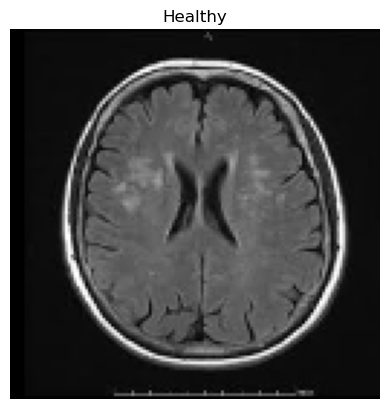

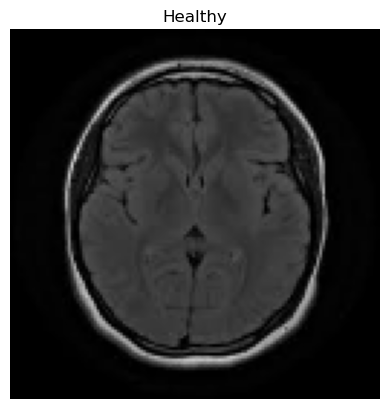

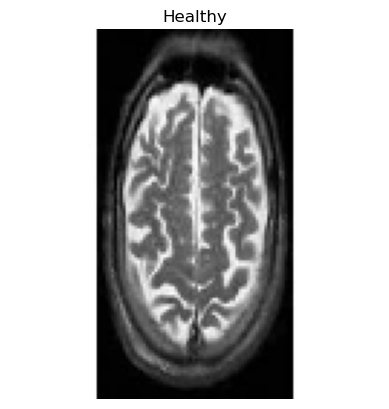

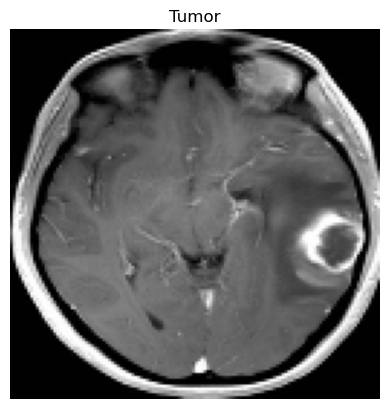

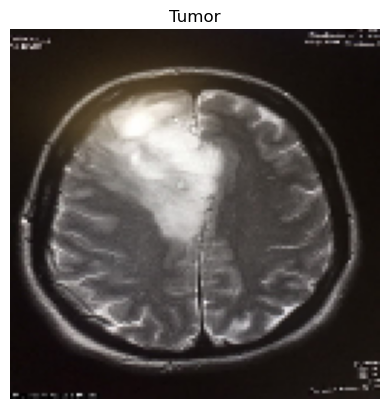

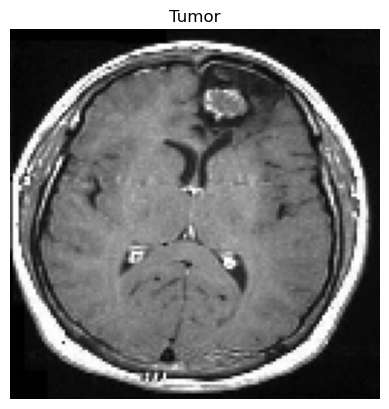

In [14]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np

names = {0: 'Healthy', 1: 'Tumor'}
dataloader = DataLoader(mri_dataset, batch_size=1, shuffle=True)

for i, sample in enumerate(dataloader):
    img = sample['image'][0]  # (128, 3, 128)
    label = sample['label'].item()

    # Convert to numpy
    img = img.numpy()

    # Normalize if needed
    if img.max() > 1.0:
        img = img / 255.0

    plt.imshow(img)
    plt.title(names[label])
    plt.axis('off')
    plt.show()

    if i == 5:
        break


In [15]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.cnn_model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5))
        
        self.fc_model = nn.Sequential(
        nn.Linear(in_features=256, out_features=120),
        nn.Tanh(),
        nn.Linear(in_features=120, out_features=84),
        nn.Tanh(),
        nn.Linear(in_features=84, out_features=1))
        
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc_model(x)
        x = F.sigmoid(x)
        
        return x

In [16]:
model=CNN()

In [17]:
model

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [18]:
# device will be 'cuda' if a GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# creating a CPU tensor
cpu_tensor = torch.rand(10).to(device)
# moving same tensor to GPU
gpu_tensor = cpu_tensor.to(device)

print(cpu_tensor, cpu_tensor.dtype, type(cpu_tensor), cpu_tensor.type())
print(gpu_tensor, gpu_tensor.dtype, type(gpu_tensor), gpu_tensor.type())

print(cpu_tensor*gpu_tensor)

tensor([0.2553, 0.9193, 0.8042, 0.6656, 0.6369, 0.6552, 0.3254, 0.7485, 0.6336,
        0.9064]) torch.float32 <class 'torch.Tensor'> torch.FloatTensor
tensor([0.2553, 0.9193, 0.8042, 0.6656, 0.6369, 0.6552, 0.3254, 0.7485, 0.6336,
        0.9064]) torch.float32 <class 'torch.Tensor'> torch.FloatTensor
tensor([0.0652, 0.8451, 0.6468, 0.4430, 0.4057, 0.4292, 0.1059, 0.5602, 0.4014,
        0.8216])


In [19]:
mri_dataset = MRI()
mri_dataset.normalize()
device = torch.device('cpu')
model = CNN().to(device)

In [20]:
dataloader=DataLoader(mri_dataset,batch_size=32,shuffle=False)

In [21]:
model.eval()
outputs = []
y_true = []

with torch.no_grad():
    for D in dataloader:
        image = D['image'].to(device)
        label = D['label'].to(device)

        # Fix dimension order: (B, H, W, C) → (B, C, H, W)
        if image.shape[1] != 3:
            image = image.permute(0, 3, 1, 2)

        y_hat = model(image)

        outputs.append(y_hat.cpu().numpy())
        y_true.append(label.cpu().numpy())


In [22]:
outputs = np.concatenate( outputs, axis=0 ).squeeze()
y_true = np.concatenate( y_true, axis=0 ).squeeze()

In [23]:
def threshold(scores,threshold=0.50, minimum=0, maximum = 1.0):
    x = np.array(list(scores))
    x[x >= threshold] = maximum
    x[x < threshold] = minimum
    return x

In [24]:
accuracy_score(y_true, threshold(outputs))

0.391304347826087

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

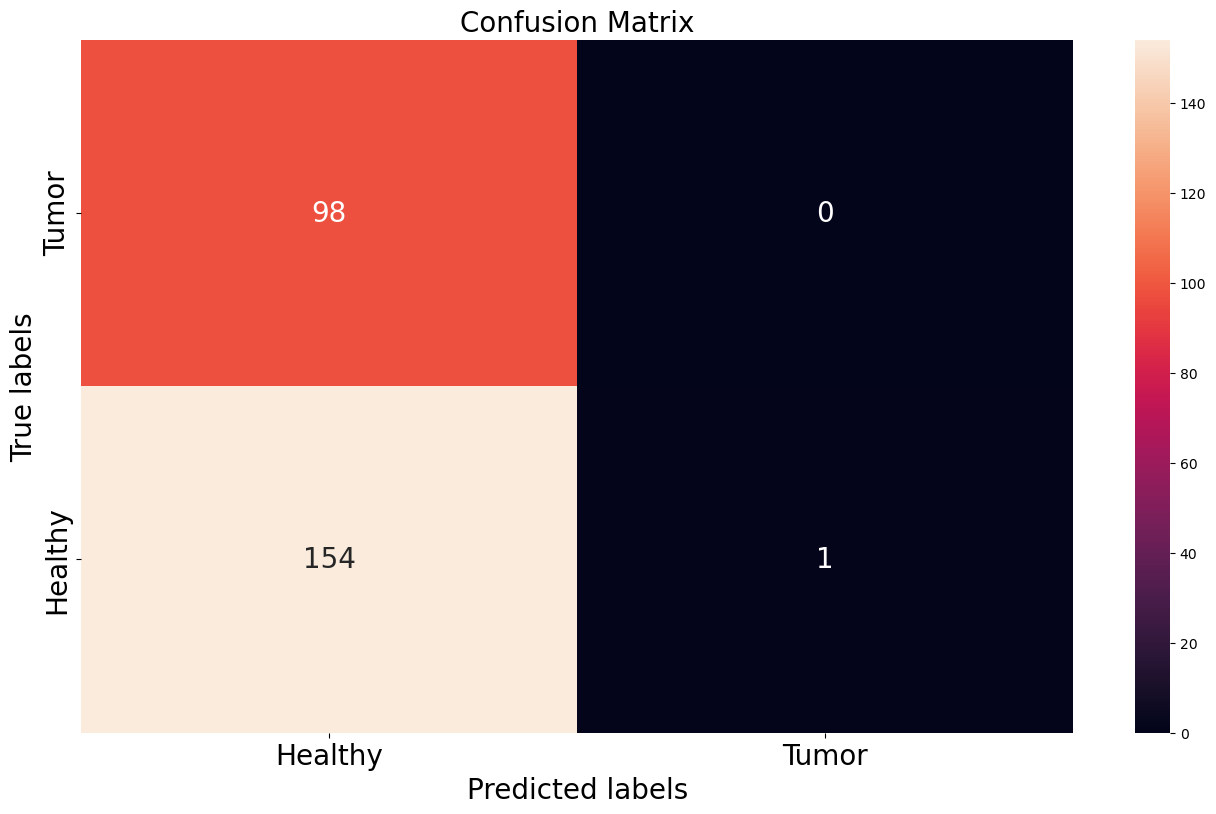

In [25]:
import seaborn as sns

plt.figure(figsize=(16,9))
cm = confusion_matrix(y_true, threshold(outputs))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={"size": 20})

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize=20)
ax.set_ylabel('True labels', fontsize=20) 
ax.set_title('Confusion Matrix', fontsize=20)
ax.xaxis.set_ticklabels(['Healthy','Tumor'], fontsize=20)
ax.yaxis.set_ticklabels(['Tumor','Healthy'], fontsize=20)

In [26]:
eta = 0.0001
EPOCH = 400
optimizer = torch.optim.Adam(model.parameters(), lr=eta)
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
model.train()

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [27]:
model.to(device)
model.train()
loss_fn = nn.BCELoss()  # or nn.BCEWithLogitsLoss() if no Sigmoid

for epoch in range(1, EPOCH + 1):
    losses = []
    for D in dataloader:
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device).float()

        if data.ndim == 4 and data.shape[-1] in (1, 3):
            data = data.permute(0, 3, 1, 2)  # HWC → CHW

        try:
            y_hat = model(data)
        except Exception as e:
            print("Model error:", e)
            print("Input shape:", data.shape)
            continue  # skip batch

        loss = loss_fn(y_hat.squeeze(), label)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    if epoch % 10== 0:
        print(f"Epoch {epoch} Loss: {np.mean(losses):.6f}")

Epoch 10 Loss: 0.628459
Epoch 20 Loss: 0.557127
Epoch 30 Loss: 0.523005
Epoch 40 Loss: 0.511842
Epoch 50 Loss: 0.499963
Epoch 60 Loss: 0.499439
Epoch 70 Loss: 0.477334
Epoch 80 Loss: 0.470636
Epoch 90 Loss: 0.456155
Epoch 100 Loss: 0.439951
Epoch 110 Loss: 0.444012
Epoch 120 Loss: 0.413826
Epoch 130 Loss: 0.398848
Epoch 140 Loss: 0.377960
Epoch 150 Loss: 0.363685
Epoch 160 Loss: 0.350073
Epoch 170 Loss: 0.318909
Epoch 180 Loss: 0.303086
Epoch 190 Loss: 0.289119
Epoch 200 Loss: 0.276237
Epoch 210 Loss: 0.253261
Epoch 220 Loss: 0.246259
Epoch 230 Loss: 0.230743
Epoch 240 Loss: 0.222681
Epoch 250 Loss: 0.193534
Epoch 260 Loss: 0.187864
Epoch 270 Loss: 0.168243
Epoch 280 Loss: 0.155707
Epoch 290 Loss: 0.143429
Epoch 300 Loss: 0.125148
Epoch 310 Loss: 0.111267
Epoch 320 Loss: 0.098235
Epoch 330 Loss: 0.088942
Epoch 340 Loss: 0.080936
Epoch 350 Loss: 0.067230
Epoch 360 Loss: 0.073219
Epoch 370 Loss: 0.049898
Epoch 380 Loss: 0.046131
Epoch 390 Loss: 0.034944
Epoch 400 Loss: 0.030616


In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

outputs = []
y_true = []

with torch.no_grad():
    for D in dataloader:
        image = D['image'].to(device)
        label = D['label'].to(device)

        # Fix channel order if needed
        if image.ndim == 4 and image.shape[-1] in (1, 3):
            image = image.permute(0, 3, 1, 2)  # HWC → CHW

        y_hat = model(image)

        outputs.append(y_hat.cpu().numpy())   # expected shape: [B, 1]
        y_true.append(label.cpu().numpy())    # shape: [B]

# Finalize arrays
outputs = np.concatenate(outputs, axis=0).flatten()  # shape: (N,)
y_true = np.concatenate(y_true, axis=0)              # shape: (N,)

In [36]:
print("Accuracy:", accuracy_score(y_true, (outputs >= 0.5).astype(int)))

Accuracy: 0.9960474308300395


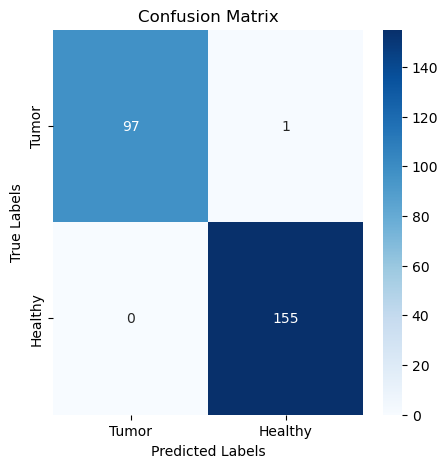

In [37]:
import seaborn as sns
y_pred = (outputs >= 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(5,5))
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues')  # `fmt='g'` for plain integer formatting

# Labels and titles
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Tumor', 'Healthy'])
ax.yaxis.set_ticklabels(['Tumor', 'Healthy'])
plt.show()

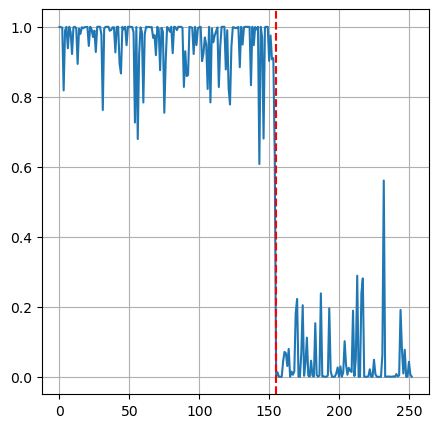

In [38]:
plt.figure(figsize=(5,5))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()

In [43]:
import torch
torch.save(model.state_dict(), "brain_tumor_model.pth")






In [ ]:
model = BrainTumorModel()
model.load_state_dict(torch.load("brain_tumor_model.pth", map_location="cpu"))
model.eval()


In [44]:
%%writefile app.py
import streamlit as st
from PIL import Image
import torch
import torch.nn as nn
import torchvision.transforms as transforms

# 🔹 Load your trained model
class BrainTumorModel(nn.Module):
    def __init__(self):
        super(BrainTumorModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 64 * 64, 128),  # Update this based on image size
            nn.ReLU(),
            nn.Linear(128, 2)  # Binary classification: tumor / no tumor
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# 🔹 Load the model weights
model = BrainTumorModel()
model.load_state_dict(torch.load("brain_tumor_model.pth", map_location=torch.device("cpu")))
model.eval()

# 🔹 Define preprocessing
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# 🔹 Streamlit interface
st.title("🧠 Brain Tumor Detection")
st.write("Upload an MRI image to check for brain tumor.")

uploaded_file = st.file_uploader("Choose an image", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    image = Image.open(uploaded_file).convert('RGB')
    st.image(image, caption="Uploaded Image", use_column_width=True)

    input_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)
        label = "Tumor" if predicted.item() == 1 else "No Tumor"

    st.subheader("Prediction:")
    st.success(label)


Overwriting app.py
